In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'

In [2]:
import numpy as np

def corr_timeseries(A, B):
    """
    Compute time-varying correlation between two arrays A and B
    of shape (time, lat, lon), returning a 1D array (time,).

    The correlation at each timestep is computed by flattening
    the 2D fields and computing Pearson correlation.
    """
    # reshape to (time, pixels)
    A2 = A.reshape(A.shape[0], -1)
    B2 = B.reshape(B.shape[0], -1)

    # subtract mean along pixels
    A2c = A2 - A2.mean(axis=1, keepdims=True)
    B2c = B2 - B2.mean(axis=1, keepdims=True)

    # numerator of Pearson r
    num = np.sum(A2c * B2c, axis=1)

    # denominator
    den = np.sqrt(np.sum(A2c**2, axis=1) * np.sum(B2c**2, axis=1))

    # avoid division by zero
    corr = num / den
    corr[den == 0] = np.nan

    return corr


# Load Streamflow Gauge Readings

In [46]:
station_id = 16240500# manoa
df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins/{station_id}.csv")
df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
df_obs['utc_timestamp'] = df_obs['hst_timestamp'].dt.tz_convert('UTC')
df_obs = df_obs.set_index('utc_timestamp').drop(columns=['hst_timestamp'])
df_obs.index = df_obs.index.tz_localize(None)

In [47]:
np.percentile(df_obs['measurement'].dropna(), q=99.98)

2.9615133333334236

In [40]:
df_obs_hourly_mean_all = df_obs.resample('h').mean()
df_obs_hourly_mean = df_obs_hourly_mean_all[(df_obs.groupby(pd.Grouper(freq='h')).size() == 4)]
df_3hourly = df_obs_hourly_mean.resample('3h').max()

threshold = 3
num_exceedance = sum(df_3hourly['measurement'] > 3)
print(f"With {threshold=}, there are {num_exceedance} occurences of \"flood\"")
df_obs = df_3hourly # rename for easy typing

With threshold=3, there are 14 occurences of "flood"


(-0.1, 5.0)

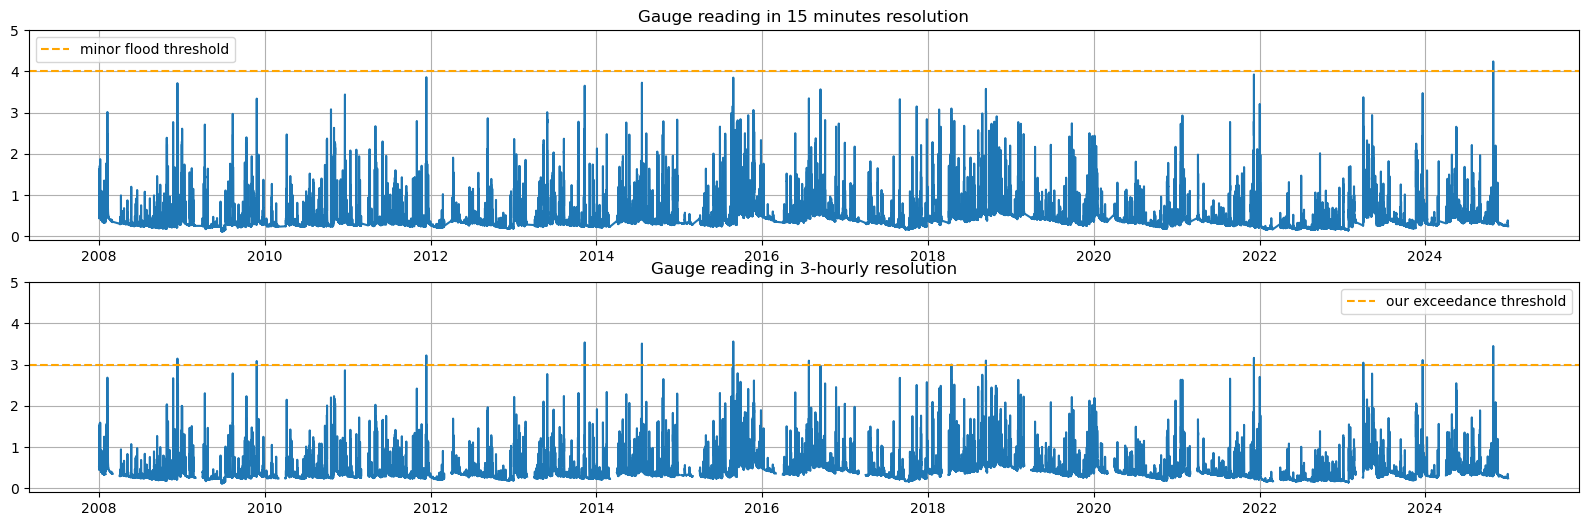

In [61]:
fig, axs = plt.subplots(2, 1, figsize=(20,6))
axs[0].plot(df_obs['measurement'])
axs[1].plot(df_3hourly['measurement'])
axs[0].grid()
axs[1].grid()
axs[0].set_title('Gauge reading in 15 minutes resolution')
axs[1].set_title('Gauge reading in 3-hourly resolution')
axs[0].axhline(y=4, color='orange', linestyle='--', label='minor flood threshold')
axs[1].axhline(y=3, color='orange', linestyle='--', label='our exceedance threshold')
axs[0].legend()
axs[1].legend()
axs[0].set_ylim(-0.1, 5)
axs[1].set_ylim(-0.1, 5)

In [45]:
np.percentile(df_obs['measurement'].dropna(), q=99.98)

3.0982510000000065

Text(0.5, 1.0, '3-hourly guage reading at Waiakeakua Stream')

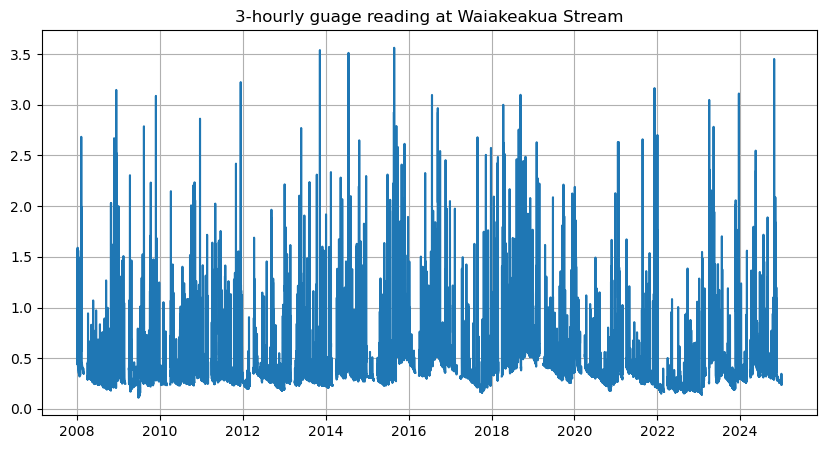

In [10]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(df_obs['measurement'])
ax.grid()
ax.set_title('3-hourly guage reading at Waiakeakua Stream')

# Load ERA5

In [11]:
all_year_data = []
for year in tqdm(range(2007, 2025)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc"))
ds_era5_obs_period = xr.concat(all_year_data, dim='time').sel(lon=slice(195, 210), lat=slice(15, 26))
ds_era5_obs_period['pr'] = ds_era5_obs_period['tp'] * 1000 * 24# m/hour to mm/day. For consistency with CMIP

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.55it/s]


In [12]:
extreme_weathers = (ds_era5_obs_period.drop_duplicates(dim='time')
                    .sel(time=df_obs.query(f'measurement >= {threshold}').index))

In [13]:
rain_type = [
    'front',# 2008 12-11
    'front',# 2009 11-26
    'front',# 2009 11-26
    'front', # 2009 12-13
    'orographic', # 2013 11-10
    'orographic', # 2014 07-20
    'orographic', # 2015 08-27
    'orographic', # 2016 07-25
    'orographic', # 2018 09-13
    'front', # 2021 12-07
    'orographic', # 2023 04-03
    'front', # 2023 12-20
    'orographic', # 2024 10-26
    'orographic', # 2024 10-26
]

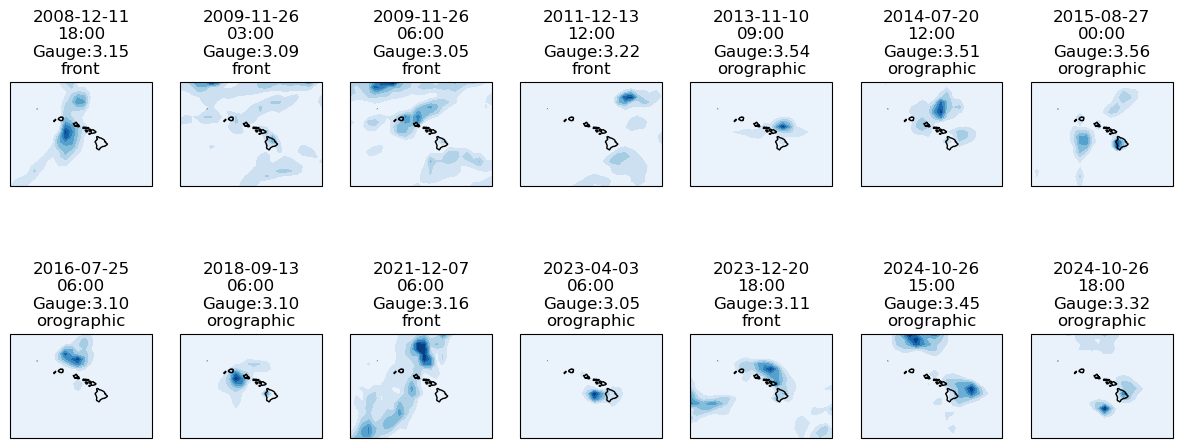

In [14]:
lons, lats = np.meshgrid(extreme_weathers.lon, extreme_weathers.lat)
fig, axs = plt.subplots(2,7, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15,6))
vmin, vmax = extreme_weathers['pr'].min(), extreme_weathers['pr'].max()
for i, ax in enumerate(axs.flatten()):
    individual_weather = extreme_weathers.isel(time=i) # xarray
    gauge = df_obs[df_obs.index == pd.Timestamp(individual_weather.time.values)]['measurement'].values[0] # pandas
    # ax.contourf(lons, lats, individual_weather['pr'], vmin=vmin, vmax=vmax, cmap='Blues')
    ax.contourf(lons, lats, individual_weather['pr'], cmap='Blues')
    ax.coastlines()
    ax.set_title(pd.Timestamp(individual_weather.time.values).strftime("%Y-%m-%d\n%H:%M") + f"\nGauge:{gauge:.2f}\n" + (rain_type[i] if i < len(rain_type) else "None"))

# fig.suptitle('Precipitation patterns associated with Threshold Exceedance at Manoa stream')
pass

In [15]:
# dry_months, wet_months = [5,6,7,8,9,10], [1,2,3,4,11,12]
# wet_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(wet_months))['pr'].mean(axis=0)
# dry_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(dry_months))['pr'].mean(axis=0)

fnt_idx = [i for i, t in enumerate(rain_type) if t == 'front']
org_idx = [i for i, t in enumerate(rain_type) if t == 'orographic']
fnt_composite = extreme_weathers.isel(time=fnt_idx)['pr'].mean(axis=0)
org_composite = extreme_weathers.isel(time=org_idx)['pr'].mean(axis=0)

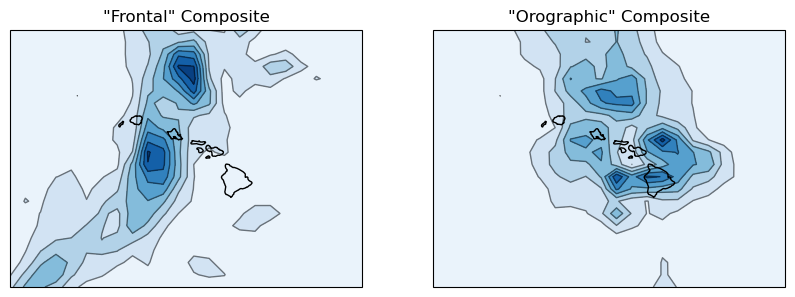

In [16]:
fig, axs = plt.subplots(1,2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 5))
for ax, composite in zip(axs.flatten(), [fnt_composite, org_composite]):
    # ax.contourf(lons, lats, composite, vmin=vmin, vmax=vmax, cmap='Blues')
    ax.contourf(lons, lats, composite, cmap='Blues')
    ax.coastlines()
    cs = ax.contour(lons, lats, composite, colors='k', linewidths=1, transform=ccrs.PlateCarree(), alpha=0.5)
    # add contour labels
    # lb = plt.clabel(cs, fontsize=12, inline=False, fmt='%0.1f');
axs[0].set_title('"Frontal" Composite')
axs[1].set_title('"Orographic" Composite')
pass

In [17]:
fnt_composite_ts = np.repeat(fnt_composite.to_numpy()[None,...], repeats=len(ds_era5_obs_period.time), axis=0)
org_composite_ts = np.repeat(org_composite.to_numpy()[None,...], repeats=len(ds_era5_obs_period.time), axis=0)

fnt_coors = corr_timeseries(ds_era5_obs_period['pr'].to_numpy(), fnt_composite_ts)
org_coors = corr_timeseries(ds_era5_obs_period['pr'].to_numpy(), org_composite_ts)

In [18]:
df_stats = pd.DataFrame({'ts': ds_era5_obs_period.time, 'front_r':fnt_coors, 'orographic_r': org_coors})
df_stats = pd.merge(df_obs, df_stats, left_index=True, right_on='ts')
df_stats['max_r'] = df_stats[['front_r', 'orographic_r']].max(axis=1)
df_stats['exceed'] = df_stats['measurement'] > 3

fpr, tpr, thresholds = roc_curve(df_stats.dropna()['exceed'], np.clip(df_stats.dropna()['max_r'], a_min=0, a_max=None))
roc_auc = auc(fpr, tpr)

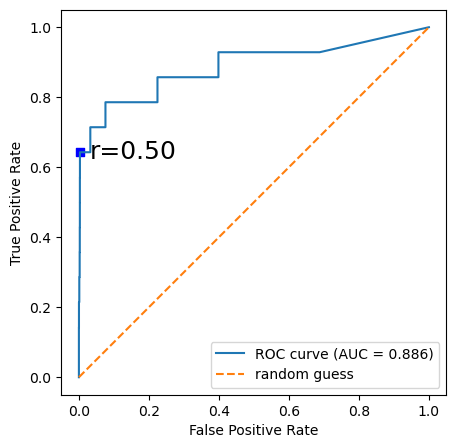

In [19]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([0,1], [0,1], linestyle='--', label='random guess')
ax.legend()

# Annotate thresholds (skip first threshold; it's always > max score)
for fp, tp, thr in zip(fpr[2::2], tpr[2::2], thresholds[2::2]):
    if abs(thr - 0.5) < 0.005:
        ax.annotate(
            f"r={thr:.2f}",
            xy=(fp, tp),
            textcoords="offset points",
            xytext=(7, -5),
            fontsize=18,
            color='black'
        )
        ax.scatter(fp, tp, marker='s', c='b')

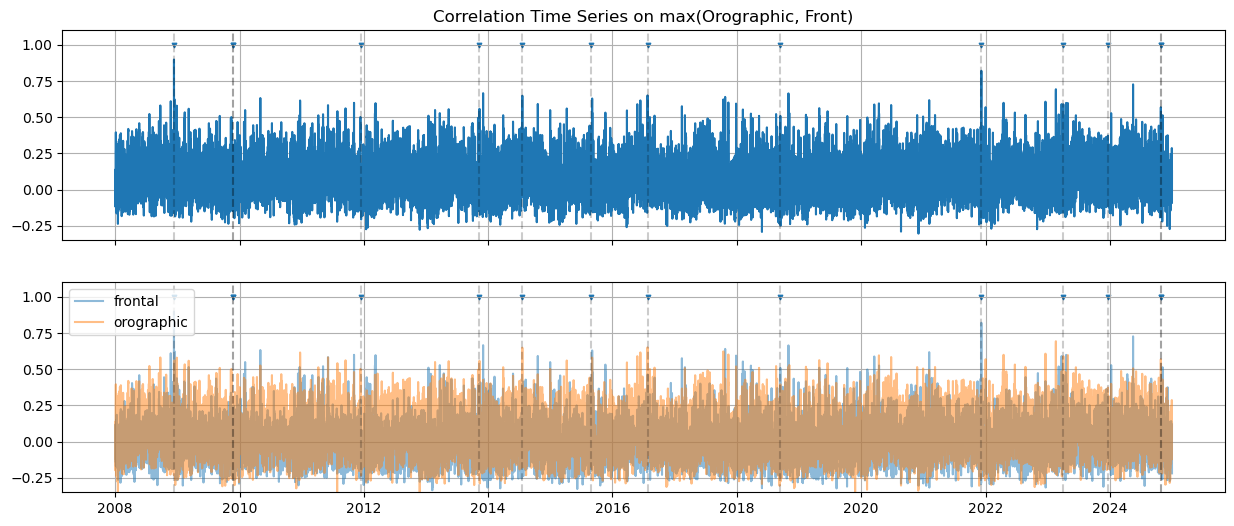

In [20]:
fig, axs = plt.subplots(2, 1, subplot_kw=dict(ylim=(-0.35, 1.1)), figsize=(15,6))
axs[0].plot(df_stats['ts'], df_stats['max_r'])
axs[1].plot(df_stats['ts'], df_stats['front_r'], alpha=0.5, label='frontal')
axs[1].plot(df_stats['ts'], df_stats['orographic_r'], alpha=0.5, label='orographic')
for ax in axs.flatten():
    ax.scatter(df_obs.query('measurement > 3').index, [1 for _ in range(len(df_obs.query('measurement > 3').index))], s=10, marker='v')
    for i in df_obs.query('measurement > 3').index:
        ax.axvline(i, linestyle='--', c='k', alpha=0.2)
    ax.grid()
axs[0].set_title('Correlation Time Series on max(Orographic, Front)')
[ax.set_xticklabels([]) for ax in axs[:-1]]
axs[1].legend()
pass

In [21]:
arr = confusion_matrix(y_true=df_stats['exceed'], y_pred=df_stats['max_r'] >= 0.5)

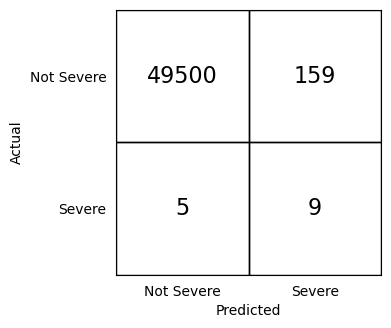

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(4,4))

# Draw 2×2 squares
for i in range(2):
    for j in range(2):
        rect = patches.Rectangle((j, 1-i), 1, 1,
                                 fill=False, edgecolor='black')
        ax.add_patch(rect)
        ax.text(j + 0.5, 1 - i + 0.5, str(arr[i, j]),
                ha='center', va='center', fontsize=16)

# Axes limits
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal')

# Tick labels like a confusion matrix
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(["Not Severe", "Severe"])
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(["Severe", "Not Severe"])   # y goes downward, so reversed

# Axis labels
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Keep frame but remove ticks
ax.tick_params(left=False, bottom=False)

plt.tight_layout()
plt.show()


In [23]:
df_stats.query('exceed == True').sort_values('max_r')

,measurement,ts,front_r,orographic_r,max_r,exceed
14460,3.223333,2011-12-13 12:00:00,-0.113759,-0.129352,-0.113759,True
8481,3.087500,2009-11-26 03:00:00,-0.015773,0.111934,0.111934,True
8482,3.047500,2009-11-26 06:00:00,0.129297,0.183521,0.183521,True
49582,3.110833,2023-12-20 18:00:00,0.033874,0.274331,0.274331,True
25280,3.562083,2015-08-27 00:00:00,0.335245,0.309264,0.335245,True
52069,3.451667,2024-10-26 15:00:00,0.107701,0.504442,0.504442,True
34186,3.098333,2018-09-13 06:00:00,0.508681,0.394688,0.508681,True
27946,3.096667,2016-07-25 06:00:00,0.451426,0.509315,0.509315,True
47490,3.047500,2023-04-03 06:00:00,0.111587,0.513735,0.513735,True
20043,3.539167,2013-11-10 09:00:00,0.040894,0.523306,0.523306,True


In [91]:
# df_stats[['ts', 'exceed']].groupby(df_stats['ts'].dt.year)['exceed'].sum()#.mean()

In [92]:
(df_stats['max_r'] > 0.5).sum()

168

In [95]:
2024 - 2008 + 1

17

In [97]:
1 / ((df_stats['max_r'] > 0.5).sum() / 17)

0.10119047619047619

In [98]:
1 / ((df_stats['max_r'] > 0.5).sum()/ df_stats.shape[0])

295.67261904761904

# Run this on historical ERA5

In [24]:
all_year_data = []
for year in tqdm(range(1981, 2011)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc"))
ds_era5_clim_period = xr.concat(all_year_data, dim='time').sel(lon=slice(195, 210), lat=slice(15, 26))
ds_era5_clim_period['pr'] = ds_era5_clim_period['tp'] * 1000 * 24

 17%|██████████████████████████████▊                                                                                                                                                          | 5/30 [00:00<00:02,  8.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.79it/s]


In [25]:
fnt_composite_ts = np.repeat(fnt_composite.to_numpy()[None,...], repeats=len(ds_era5_clim_period.time), axis=0)
org_composite_ts = np.repeat(org_composite.to_numpy()[None,...], repeats=len(ds_era5_clim_period.time), axis=0)

fnt_coors = corr_timeseries(ds_era5_clim_period['pr'].to_numpy(), fnt_composite_ts)
org_coors = corr_timeseries(ds_era5_clim_period['pr'].to_numpy(), org_composite_ts)

df_stats_era5_historical = pd.DataFrame({'ts': ds_era5_clim_period.time, 'front_r':fnt_coors, 'orographic_r': org_coors})
df_stats_era5_historical['max_r'] = df_stats_era5_historical[['front_r', 'orographic_r']].max(axis=1)

In [26]:
sum(df_stats_era5_historical['max_r'] > 0.5)

259

# Run this on historical CMIP

In [27]:
# historical
ds_gcm_historical = xr.open_dataset(f"{base_dir}/wasfia/GFDL_CM4C192_pr_hawaii_1981_2010.nc").sel(lon=slice(195, 210), lat=slice(15, 26))
fnt_composite_ts = np.repeat(fnt_composite.to_numpy()[None,...], repeats=len(ds_gcm_historical.time), axis=0)
org_composite_ts = np.repeat(org_composite.to_numpy()[None,...], repeats=len(ds_gcm_historical.time), axis=0)

fnt_coors = corr_timeseries(ds_gcm_historical['pr'].to_numpy(), fnt_composite_ts)
org_coors = corr_timeseries(ds_gcm_historical['pr'].to_numpy(), org_composite_ts)

df_stats_gcm_historical = pd.DataFrame({'ts': pd.date_range('1981-01-01 00:00', '2010-12-31-21:00', freq='3h'), 'front_r':fnt_coors, 'orographic_r': org_coors})
df_stats_gcm_historical['max_r'] = df_stats_gcm_historical[['front_r', 'orographic_r']].max(axis=1)

In [105]:
sum(df_stats_gcm_historical['max_r'] > 0.5), "over", df_stats_gcm_historical.shape[0]

(516, 'over', 87656)

In [28]:
# future
ds_gcm_future = xr.open_dataset(f"{base_dir}/wasfia/GFDL_CM4C192_pr_hawaii_future_2015_2050.nc").sel(lon=slice(195, 210), lat=slice(15, 26))
fnt_composite_ts = np.repeat(fnt_composite.to_numpy()[None,...], repeats=len(ds_gcm_future.time), axis=0)
org_composite_ts = np.repeat(org_composite.to_numpy()[None,...], repeats=len(ds_gcm_future.time), axis=0)

fnt_coors = corr_timeseries(ds_gcm_future['pr'].to_numpy(), fnt_composite_ts)
org_coors = corr_timeseries(ds_gcm_future['pr'].to_numpy(), org_composite_ts)

df_stats_gcm_future = pd.DataFrame({'ts': pd.date_range('2015-01-01 00:00', '2050-12-31-21:00', freq='3h'), 'front_r':fnt_coors, 'orographic_r': org_coors})
df_stats_gcm_future['max_r'] = df_stats_gcm_future[['front_r', 'orographic_r']].max(axis=1)

/tmp/ipykernel_1262774/2543235321.py:26: RuntimeWarning: invalid value encountered in divide
  corr = num / den


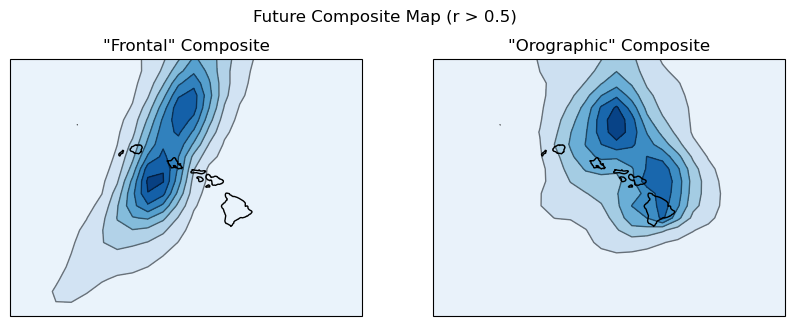

In [29]:
fig, axs = plt.subplots(1,2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 5))
for i, (ax, composite) in enumerate(zip(axs.flatten(), [fnt_composite, org_composite])):
    if i == 0:
        conditional_composite = ds_gcm_future.isel(time=df_stats_gcm_future['front_r'] > 0.5)['pr'].mean(axis=0)
    else:
        conditional_composite = ds_gcm_future.isel(time=df_stats_gcm_future['orographic_r'] > 0.5)['pr'].mean(axis=0)
    ax.contourf(lons, lats, conditional_composite, cmap='Blues')
    ax.coastlines()
    cs = ax.contour(lons, lats, conditional_composite, colors='k', linewidths=1, transform=ccrs.PlateCarree(), alpha=0.5)
    # add contour labels
    # lb = plt.clabel(cs, fontsize=12, inline=False, fmt='%0.1f');
axs[0].set_title('"Frontal" Composite')
axs[1].set_title('"Orographic" Composite')
fig.suptitle('Future Composite Map (r > 0.5)', x=0.5, y=0.85)
pass

(array([0.36883117, 0.09350649, 0.07272727, 0.01038961, 0.00519481,
        0.        , 0.05714286, 0.02597403, 0.06233766, 0.21298701]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

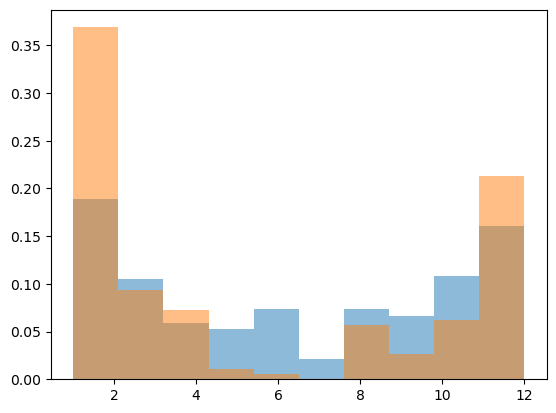

In [40]:
fig, ax = plt.subplots(1)
ax.hist(df_stats_gcm_future[df_stats_gcm_future['orographic_r'] >= 0.5]['ts'].dt.month, density=True, alpha=0.5)
ax.hist(df_stats_gcm_future[df_stats_gcm_future['front_r'] >= 0.5]['ts'].dt.month, density=True, alpha=0.5)

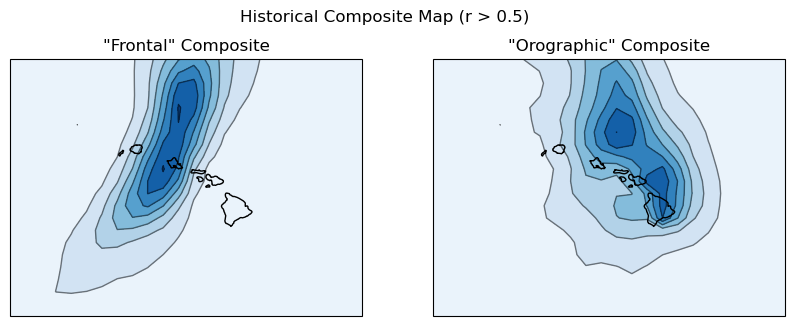

In [134]:
fig, axs = plt.subplots(1,2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 5))
for i, (ax, composite) in enumerate(zip(axs.flatten(), [fnt_composite, org_composite])):
    if i == 0:
        conditional_composite = ds_gcm_historical.isel(time=df_stats_gcm_historical['front_r'] > 0.5)['pr'].mean(axis=0)
    else:
        conditional_composite = ds_gcm_historical.isel(time=df_stats_gcm_historical['orographic_r'] > 0.5)['pr'].mean(axis=0)
    ax.contourf(lons, lats, conditional_composite, cmap='Blues')
    ax.coastlines()
    cs = ax.contour(lons, lats, conditional_composite, colors='k', linewidths=1, transform=ccrs.PlateCarree(), alpha=0.5)
    # add contour labels
    # lb = plt.clabel(cs, fontsize=12, inline=False, fmt='%0.1f');
axs[0].set_title('"Frontal" Composite')
axs[1].set_title('"Orographic" Composite')
fig.suptitle('Historical Composite Map (r > 0.5)', x=0.5, y=0.85)
pass

In [107]:
sum(df_stats_gcm_future['max_r'] > 0.5), 'over', df_stats_gcm_future.shape[0]

(417, 'over', 105192)

Text(0.5, 1.0, 'Q-Q plot for r-values from HighresMIP historical and future')

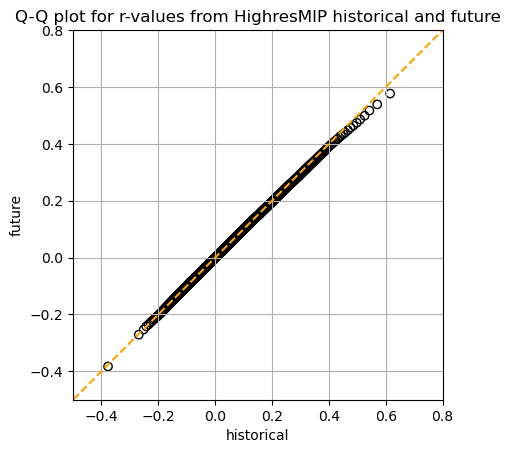

In [110]:
fig, ax = plt.subplots(1)
ax.plot([-1,1], [-1,1], c='orange', linestyle='--')
ax.scatter(
    df_stats_gcm_historical['max_r'].quantile(q=np.linspace(0,1,1001)[:-1]),
    df_stats_gcm_future['max_r'].quantile(q=np.linspace(0,1,1001)[:-1]),
    marker='o', facecolor='none', edgecolor='k'
)
ax.set_xlim((-0.5, 0.8)), ax.set_ylim((-0.5, 0.8))
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel('historical'), ax.set_ylabel('future')
ax.set_title('Q-Q plot for r-values from HighresMIP historical and future')

0.6644876084375142
0.6081481648530104


Text(0.5, 0, 'r')

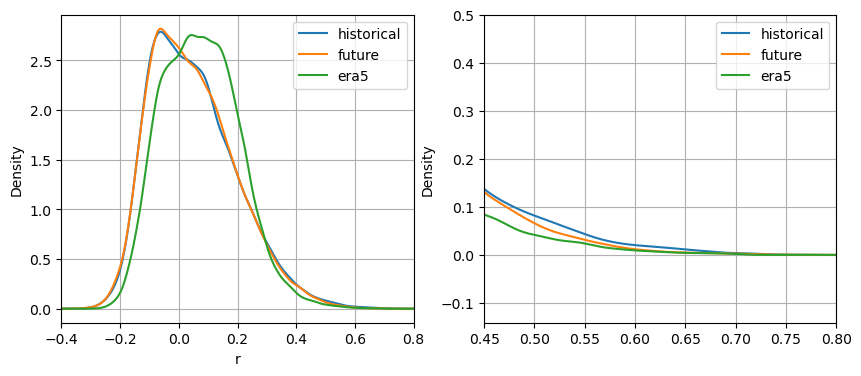

In [111]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
df_stats_gcm_historical['max_r'].plot.kde(ax=axs[0], label='historical')
df_stats_gcm_future['max_r'].plot.kde(ax=axs[0], label='future')
df_stats_era5_historical['max_r'].plot.kde(ax=axs[0], label='era5')
df_stats_gcm_historical['max_r'].plot.kde(ax=axs[1], label='historical')
df_stats_gcm_future['max_r'].plot.kde(ax=axs[1], label='future')
df_stats_era5_historical['max_r'].plot.kde(ax=axs[1], label='era5')

axs[0].set_xlim(-0.4, 0.8)
axs[1].set_xlim(0.45, 0.8), axs[1].set_ylim(None, 0.5)
axs[0].grid(), axs[1].grid()
axs[0].legend(), axs[1].legend()
print(df_stats_gcm_historical['max_r'].skew())
print(df_stats_gcm_future['max_r'].skew())
axs[0].set_xlabel('r')
axs[1].set_xlabel('r')
# pass
# pdf of ERA5, return period plot for exceeding R=0.5, q-q plot
# calculate composite from CMIP (wet, dry) to confirm
# multiple composite (clustering, domain expertise) frontal vs orographic
# conditional pobability

In [18]:
# fig, axs = plt.subplots(2, 1, figsize=(15,6))
# axs[0].plot(df_stats_gcm_historical['ts'], df_stats_gcm_historical['max_r'], alpha=0.5)
# axs[0].plot(df_stats_era5_historical['ts'], df_stats_era5_historical['max_r'], alpha=0.5)
# axs[0].set_title('Correlation Time Series, GCM historical')
# axs[0].grid()

# axs[1].plot(df_stats_gcm_future['ts'], df_stats_gcm_future['max_r'])
# axs[1].grid()